# 01 Plot spatial data with OWS

The DE Africa Map `https://maps.digitalearth.africa/` uses an OWS (OGS Web Services) endpoint to display spatial data in a colourful and interactive manner.
In the Sandbox environment, we usually plot data using Python packages such as `xarray.plot` and `matplotlib`. However, this does not display the data the same way (colours and scale) as the OWS settings. 

In this notebook we will use the `ows-datacube` package to emulate the OWS settings inside the Sandbox.

This is useful for:
* Testing new display styles before adding them to the DE Africa Map
* Re-creating images from the Map in the Sandbox

More detail is provided in the [OWS Styling How-to Guide](https://datacube-ows.readthedocs.io/en/latest/styling_howto.html).

## 1.1 Import OWS styling package

In [17]:
%matplotlib inline

from datacube import Datacube
dc = Datacube()

from datacube_ows.styles.api import StandaloneStyle, apply_ows_style_cfg, xarray_image_as_png, plot_image_with_style_cfg

Each of the examples below follows the same few steps:

1. Load DE Africa data using `dc.load` for the selected area and time period
2. Define OWS colour ramp
3. Use colour ramp to define OWS style
4. Apply OWS style to a plot of the data

Colour ramps and styles can easily be modified. This is explained in a separate notebook.

## 1.2 Example 1: Local area testing

In [2]:
lat = 14.223452625252513
lon = 36.0121536254873
buffer = 0.2
time = ('2020')

wofs_data = dc.load(
    product='wofs_ls_summary_annual',
    measurements=['frequency'],
    latitude=(lat-buffer, lat+buffer),
    longitude=(lon-buffer, lon+buffer),
    time=time,
    output_crs="EPSG:6933",
    resolution=(-30,30),
    group_by="solar_day"
)

In [27]:
mako_colour_ramp = [
    {"value": 0.0, "color": "#FFFFFF", "alpha": 0.0},
        {"value": 0.02, "color": "#FFFFFF", "alpha": 0.0},
        {"value": 0.05, "color": '#aee3c0', "alpha": 0.25},
        {"value": 0.1, "color": '#6dd3ad', "alpha": 0.75},
        {"value": 0.2, "color": '#44bcad'},
        {"value": 0.3, "color": '#35a1ab'},
        {"value": 0.4, "color": '#3487a6'},
        {"value": 0.5, "color": '#366da0'},
        {"value": 0.6, "color": '#3d5296'},
        {"value": 0.7, "color": '#403974'},
        {"value": 0.8, "color": '#35264c'},
        {"value": 0.9, "color": '#231526'},
    ]

In [4]:
style_wofs_summary_annual_frequency = {
    "index_function": {
        "function": "datacube_ows.band_utils.single_band",
        "mapped_bands": True,
        "kwargs": {
            "band": "frequency", # this measurement must be in the loaded dataset
        },
    },
    "needed_bands": ["frequency"],
    "color_ramp": mako_colour_ramp, # using colour ramp defined above
}

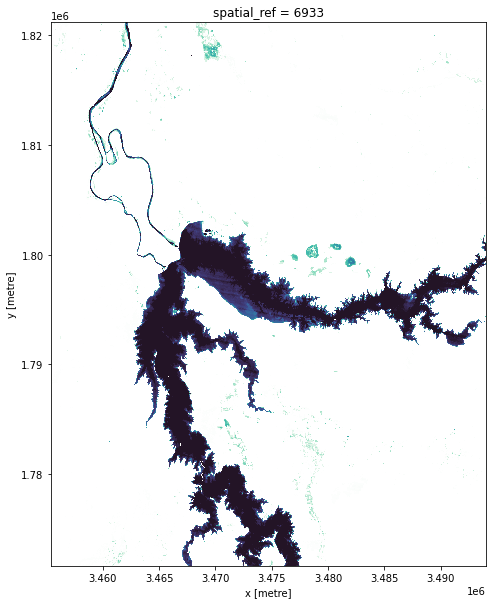

In [18]:
plot_image_with_style_cfg(style_wofs_summary_annual_frequency, wofs_data)

*The style used here is taken from* https://github.com/digitalearthafrica/config/blob/master/services/ows_refactored/wofs/style_wofs_ls.py *under* `style_wofs_summary_annual_frequency`.

## 1.3 Example 2: Continental Africa

DE Africa OWS applies one colour scheme and scale across the entire dataset. This means what might look good in one area may wash out visuals in another. It can be hard to find the right balance but looking at the entirety of the dataset can help.

In this example we will load data for the vegetation band index NDVI from the Sentinel-2 GeoMAD. There are similar methods of dealing with RGB and false-colour plots which can be found in the [OWS Styling How-to Guide](https://datacube-ows.readthedocs.io/en/latest/styling_howto.html).

In [6]:
from deafrica_tools.dask import create_local_dask_cluster

In [7]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:41617 Dashboard: /user/eefaye.chong@digitalearthafrica.org/proxy/8787/status,Cluster Workers: 1 Cores: 4 Memory: 28.14 GB


In [25]:
whole_africa_data = dc.load(
    product='gm_ls8_ls9_annual_lowres',
    measurements=['red','nir'],
    output_crs="EPSG:6933",
    resolution=(-10000,10000),
    dask_chunks={'x': 3000, 'y': 3000},
    group_by="solar_day",
    time='2021')

In [26]:
whole_africa_data = whole_africa_data.compute()

In [20]:
orylgn_colour_ramp = [
        {"value": -0.0, "color": "#8F3F20", "alpha": 0.0},
        {"value": 0.0, "color": "#8F3F20", "alpha": 1.0},
        {"value": 0.1, "color": "#A35F18"},
        {"value": 0.2, "color": "#B88512"},
        {"value": 0.3, "color": "#CEAC0E"},
        {"value": 0.4, "color": "#E5D609"},
        {"value": 0.5, "color": "#FFFF0C"},
        {"value": 0.6, "color": "#C3DE09"},
        {"value": 0.7, "color": "#88B808"},
        {"value": 0.8, "color": "#529400"},
        {"value": 0.9, "color": "#237100"},
        {"value": 1.0, "color": "#114D04"},
    ]

In [23]:
style_ls_ndvi = {
    "index_function": {
        "function": "datacube_ows.band_utils.norm_diff",
        "mapped_bands": True,
        "kwargs": {"band1": "nir", "band2": "red"},
    },
    "needed_bands": ["red", "nir"],
    "color_ramp": orylgn_colour_ramp,
}

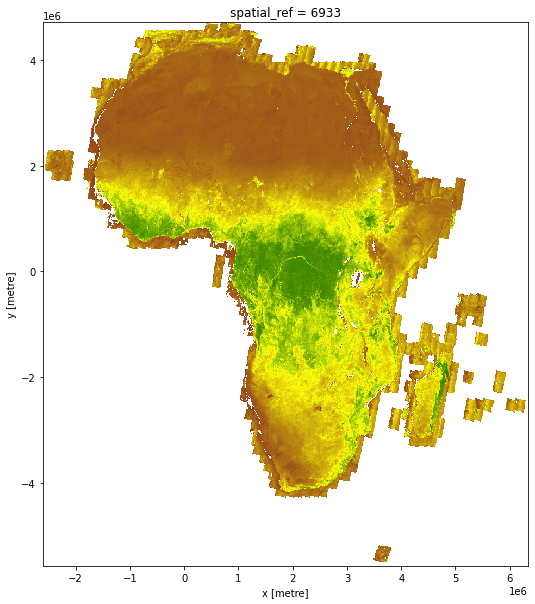

In [24]:
plot_image_with_style_cfg(style_ls_ndvi, whole_africa_data)

*The style used here is taken from* https://github.com/digitalearthafrica/config/blob/master/services/ows_refactored/surface_reflectance/style_sr_cfg.py *under* `style_ls_ndvi`.

Now we are able to apply an OWS style to a dataset and plot it. The next notebook covers choosing and customising colour schemes.